# Replaying the Interaction Dataset

This notebook shows how to use the interaction dataset in bark. Details on the dataset: https://arxiv.org/abs/1910.03088

In [1]:
from modules.runtime.scenario.scenario_generation.interaction_dataset_scenario_generation import \
    InteractionDatasetScenarioGeneration
from modules.runtime.commons.parameters import ParameterServer
from modules.runtime.viewer.matplotlib_viewer import MPViewer
from modules.runtime.viewer.video_renderer import VideoRenderer
import os
import os.path
import argparse
import matplotlib.pyplot as plt

from IPython.display import clear_output

### Add the path to the cloned interaction dataset here
- The current path expands to '~/Repositories/interaction_dataset'. 
- The easiest way would be if we all clone to the same path, so we don't have to change the path each time we merge.
- The bazel command doesn't need to be changed so. Just keep `bazel run docs/tutorials:run` running.

In [3]:
path_to_interaction_dataset = os.path.join(os.path.expanduser('~'), "praktikum/interaction_dataset")
if not os.path.exists(path_to_interaction_dataset):
    raise ValueError('Interaction dataset not found at location:', path_to_interaction_dataset)

### Use the interaction dataset

Here, we specify which slize of the dataset shall be loaded. **Note that the files have to exist!** The dataset itself is not included in bark! We here specify the parameters:
- The map: "MapFilename"
- The vehicle trajectories: "TrackFilename"
- Which vehicles: "TrackIds"
- Start time: "StartTs"
- End Time: "EndTs"
- Who's treated as ego agent (aka. where are metrics evaluated): "EgoTrackId"


In [4]:
# Lets define the secnario:
param_server = ParameterServer()
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["MapFilename"] = os.path.join(path_to_interaction_dataset, "DR_DEU_Merging_MT/map/DR_DEU_Merging_MT_v01_shifted.xodr")
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackFilename"] = os.path.join(path_to_interaction_dataset, "DR_DEU_Merging_MT/tracks/vehicle_tracks_013.csv")
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackIds"] = [63,64,65,66,67,68]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["StartTs"] = 232000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EndTs"] = 259000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EgoTrackId"] = 66

In [5]:
# Create the scenario
scenario_generation = InteractionDatasetScenarioGeneration(num_scenarios=1, random_seed=0, params=param_server)
scenario = scenario_generation.create_single_scenario()

/home/pedro/.cache/bazel/_bazel_pedro/18421c8926ea6aefd77fbccffb5722da/execroot/bark_project/bazel-out/k8-fastbuild/bin/docs/tutorials/run.runfiles/bark_project/modules/runtime/commons/xodr_parser.py:105: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):


In [6]:
# Initialize
sim_step_time = 0.2
sim_time_steps = 130

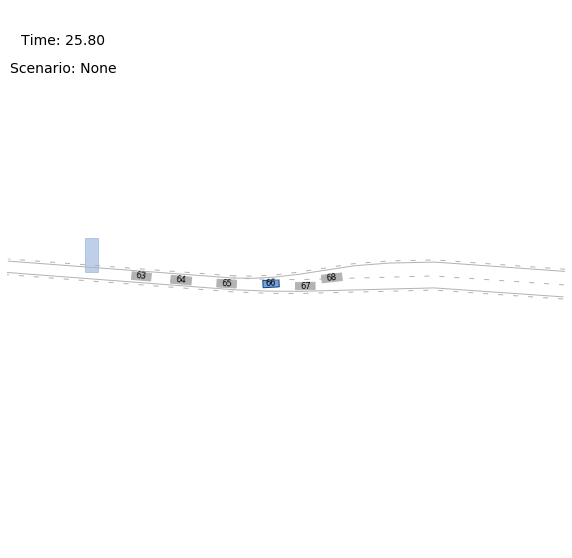

In [8]:
# Run the scenario in a loop
world_state = scenario.get_world_state()
for _ in range(0, sim_time_steps):
    world_state.DoPlanning(sim_step_time)
    fig = plt.figure(figsize=[10, 10])
    viewer = MPViewer(params=param_server, use_world_bounds=True, axis=fig.gca())
    viewer.drawWorld(world_state, scenario._eval_agent_ids)
    world_state.DoExecution(sim_step_time)
    clear_output(wait=True)

# Replacing an Agent

Based on the above, we replace one agent with another agent model. For this, we just add a parameter to the server. Here we chose the replate the agent 67 with an IDM with standard parameters.

In [9]:
# Insert IDM Agent
param_server_idm = param_server
param_server_idm["Scenario"]["Generation"]["InteractionDataset"]["BehaviorModel"] = {"67":"BehaviorIDMClassic"}

In [10]:
# Override the scenario
scenario_generation_idm = InteractionDatasetScenarioGeneration(num_scenarios=1, random_seed=0, params=param_server_idm)
scenario = scenario_generation_idm.create_single_scenario()

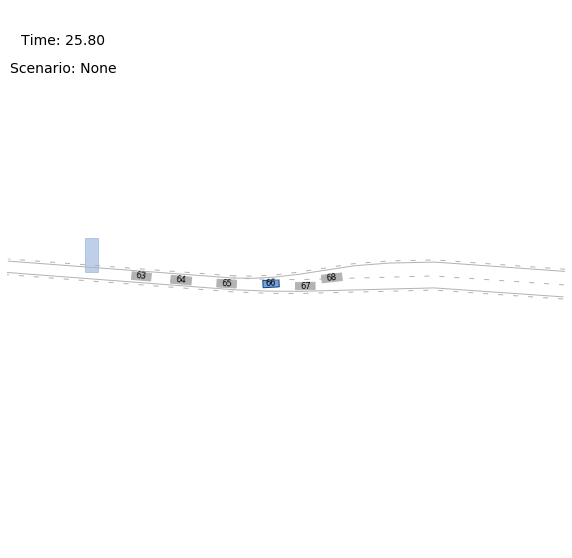

In [11]:
# Run the scenario
world_state = scenario.get_world_state()
for _ in range(0, sim_time_steps):
    world_state.DoPlanning(sim_step_time)
    fig = plt.figure(figsize=[10, 10])
    viewer = MPViewer(params=param_server, use_world_bounds=True, axis=fig.gca())
    viewer.drawWorld(world_state, scenario._eval_agent_ids)
    world_state.DoExecution(sim_step_time)
    clear_output(wait=True)


That's it. We now have replayed one slice of the interaction dataset in bark and inserted an IDM agent, that is able to follow the given traffic.